# Milestone 3 - Regression Simulation 

## Author - Natalie Moore



### Note
Please clearly outline the results with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

In [1]:
# Load necessary libraries
import math
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as ss
import statsmodels.graphics.tsaplots as splt
import statsmodels.tsa.seasonal as sts
import statsmodels.tsa.arima_process as arima
from statsmodels.tsa.arima_model import ARIMAResults 
from statsmodels.tsa.stattools import adfuller
from scipy.stats import zscore
import sklearn.linear_model as lm

In [2]:
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/CADairyProduction.csv"
dairy = pd.read_csv(fileName)
dairy.index = pd.date_range(start = '1-1-1995', end = '12-31-2013', freq = 'M')
dairy.columns = ['Year', 'Month', 'Cotagecheese', 'Icecream', 'Milk', 'FatPrice', 'MonthCount', 'monthNumSqred', 'monthNumCubed']
dairy.dtypes

Year               int64
Month             object
Cotagecheese     float64
Icecream         float64
Milk             float64
FatPrice         float64
MonthCount         int64
monthNumSqred      int64
monthNumCubed      int64
dtype: object

Text(0.5,1,'Three California Dairy Farm Production time series')

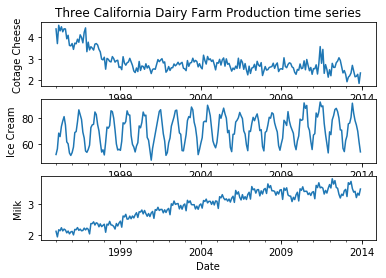

In [3]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1)
dairy.Cotagecheese.plot(ax = ax1)
dairy.Icecream.plot(ax = ax2)
dairy.Milk.plot(ax = ax3)
ax1.set_ylabel('Cotage Cheese')
ax2.set_ylabel('Ice Cream')
ax3.set_ylabel('Milk')
ax3.set_xlabel('Date')
ax1.set_title('Three California Dairy Farm Production time series')

Index(['Year', 'Month', 'Cotagecheese', 'Icecream', 'Milk', 'FatPrice',
       'MonthCount', 'monthNumSqred', 'monthNumCubed', 'Milk_log'],
      dtype='object')

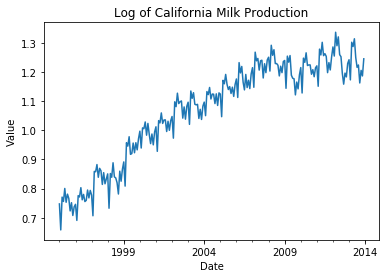

In [4]:
#focusing on Milk production:

#function to plot a simple time series
def plot_ts(ts, title):
    ts.plot()
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')

dairy['Milk_log'] = np.log(dairy.Milk)
plot_ts(dairy.Milk_log, 'Log of California Milk Production')
dairy.columns

From the time series above, it is clear that Milk production has a significant trend. There is also clearly a significant seasonal component. The seasonal component seems to exibit a slight sinusoidal pattern with near-constant magnitude over time.

I will now perform the STL decomosition of the time series.

               resid     trend  seasonal
1995-01-31       NaN       NaN  0.009169
1995-02-28       NaN       NaN -0.063646
1995-03-31       NaN       NaN  0.046570
1995-04-30       NaN       NaN  0.026694
1995-05-31       NaN       NaN  0.053586
1995-06-30       NaN       NaN  0.004263
1995-07-31  0.026259  0.746283  0.008616
1995-08-31  0.016510  0.747581  0.002307
1995-09-30  0.014267  0.749151 -0.039741
1995-10-31  0.008047  0.750003 -0.006162
1995-11-30 -0.003504  0.750755 -0.039215
1995-12-31 -0.011135  0.751219 -0.002441
               resid     trend  seasonal
2013-01-31  0.002499  1.230179  0.009169
2013-02-28  0.006582  1.229856 -0.063646
2013-03-31  0.024035  1.231219  0.046570
2013-04-30  0.028554  1.231778  0.026694
2013-05-31  0.027831  1.232307  0.053586
2013-06-30  0.012240  1.233112  0.004263
2013-07-31       NaN       NaN  0.008616
2013-08-31       NaN       NaN  0.002307
2013-09-30       NaN       NaN -0.039741
2013-10-31       NaN       NaN -0.006162
2013-11-30      

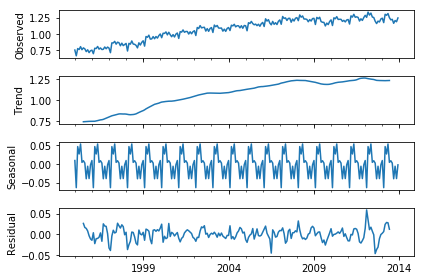

In [5]:
#function for multiplicative decomposition model 
import statsmodels.tsa.seasonal as sts
def decomp_ts(ts, freq = 'M', model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model) #, freq = freq)
    #resplot = res.plot()
    res.plot()
    return(pd.DataFrame({'resid': res.resid, 
                         'trend': res.trend, 
                         'seasonal': res.seasonal},
                       index = ts.index) )

dairy_decomp = decomp_ts(dairy.Milk_log)
print(dairy_decomp.head(12))
print(dairy_decomp.tail(12))

decomp = dairy_decomp.seasonal

Above is the decomposed trend and seasonal component. This confirms that there is a significant trend and that the seasonal component is constant over time. 

Now let's look at the Dicky Fuller test to see if the residual is stationary or not.

In [6]:
#function for the Dicky Fuller test
def DF_Test(ts):
    stationary = adfuller(ts)
    ## Print the results
    print('D-F statistic = ' + str(stationary[0]))
    print('p-value = ' + str(stationary[1]))
    print('number of lags used = ' + str(stationary[2]))
    print('Critical value at 5% confidence = ' + str(stationary[4]['5%']))
    print('Critical value at 10% confidence = ' + str(stationary[4]['10%']))
DF_Test(dairy_decomp.resid[6:-6])    

D-F statistic = -8.280935682685259
p-value = 4.521792223864596e-13
number of lags used = 7
Critical value at 5% confidence = -2.875537986778846
Critical value at 10% confidence = -2.574231080806213


The D-F statistic is large, indicating that we can reject the null hypothesis about the residual's movement. Also, the p-value is extremely small which indicates the differences due to randomness are unlikely.

This all means that Milk production is not stationary.

I will now attempt to find the best ARIMA model order below, then execute the ARIMA model using the best order.

In [7]:
#functions for finding the best order for the ARIMA model
def model_ARIMA_2(ts, order):
    from statsmodels.tsa.arima_model import ARIMA
    from statsmodels.tsa.arima_model import ARIMAResults    
    model = ARIMA(ts, order = order)
    model_fit = model.fit(disp=0, method='mle', trend='nc')
    BIC = ARIMAResults.bic(model_fit)
    print('Testing model of order: ' + str(order) + ' with BIC = ' + str(BIC))
    return(BIC, order, model_fit)

def step_ARIMA(resid, p_max, d_max, q_max):
    from statsmodels.tsa.arima_model import ARIMAResults    
    from statsmodels.tsa.arima_model import ARIMA
    best_BIC = 9999999999999999.0
    for p in range(p_max + 1):
        for d in range(d_max + 1):
            for q in range(q_max + 1):
                if(p > 0 or q > 0):
                    try:
                        order = (p, d, q)
                        BIC, order, model = model_ARIMA_2(resid, order)
                        if(BIC < best_BIC):
                            best_model = model
                            best_BIC = BIC
                            best_order = order
                    except: 
                        pass        
    return(best_BIC, best_order, best_model) 

BIC, order, model = step_ARIMA(dairy_decomp.resid[6:-6], 3, 3, 3)    
print('***************************************')
print('Best model with BIC = ' + str(BIC) + ' and with order '+ str(order))

Testing model of order: (0, 0, 1) with BIC = -1259.2535158002456
Testing model of order: (0, 0, 2) with BIC = -1263.3895258177872
Testing model of order: (0, 0, 3) with BIC = -1261.65898902056
Testing model of order: (0, 1, 1) with BIC = -1208.1215115966227
Testing model of order: (0, 1, 2) with BIC = -1242.5518231300798
Testing model of order: (0, 1, 3) with BIC = -1246.980072361376
Testing model of order: (0, 2, 1) with BIC = -1188.1204125665993
Testing model of order: (1, 0, 0) with BIC = -1266.337871220621
Testing model of order: (1, 0, 1) with BIC = -1262.7075998773828
Testing model of order: (1, 0, 2) with BIC = -1259.395678185271
Testing model of order: (1, 1, 0) with BIC = -1206.0860866049395
Testing model of order: (1, 2, 0) with BIC = -1085.33203648243
Testing model of order: (2, 0, 0) with BIC = -1263.784872165231
Testing model of order: (2, 0, 1) with BIC = -1294.740052170079
Testing model of order: (2, 0, 2) with BIC = -1291.3156033726543
Testing model of order: (2, 1, 0) 

In [ ]:
#function for the ARIMA model using the best order found above: (2, 0, 1)
def model_ARIMA(ts, order):
    from statsmodels.tsa.arima_model import ARIMA
    model = ARIMA(ts, order = order)
    model_fit = model.fit(disp=0, method='mle', trend='nc')
    print(model_fit.summary())
    return(model_fit)

arima_dairy = model_ARIMA(dairy_decomp.resid[6:-6], order = (2,0,1))

We can now see that the standard error of the AR coefficients are not equal in magnatide to the coefficients themselves. Furthermore, the confidence interval does not overlap zero. This is a good model and not generalize.

I will now train our model to forcast into the future.

In [ ]:
## Create new features, the count of months from the start of the
## series and the square of the count of months.
dairy.loc[:, 'MonthCount'] = [float(i + 1) for i in range(len(dairy.Milk_log))]
dairy.loc[:, 'MonthCount_2'] = [x**2 for x in dairy.MonthCount]

## Normalize the time features
from scipy.stats import zscore
dairy.loc[:, ['MonthCount', 'MonthCount_2']] = dairy.loc[:, ['MonthCount', 'MonthCount_2']].apply(zscore)

## Create dummy variables for the months
years = int(len(dairy.Milk_log)/12)
dairy.loc[:, 'Month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] * years
dummies = pd.get_dummies(dairy.loc[:, 'Month'])
dairy[list(dummies.columns)] = dummies
## Print the head of the data frame to look at the dummy variables.
dairy.head(12)
dairy.dtypes

In [ ]:
import sklearn.linear_model as lm
X = dairy.loc[:'2012-12-31', ['MonthCount', 'MonthCount_2', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].as_matrix()
Y = dairy.loc[:'2012-12-31', 'Milk_log'].as_matrix()
lm_mod = lm.LinearRegression(fit_intercept = False)
mod_fit = lm_mod.fit(X, Y)
## and the predictions and the residual
dairy.loc[:'2012-12-31', 'scores'] = mod_fit.predict(X)
dairy.loc[:'2012-12-31', 'resids'] = dairy.loc[:'2013-12-31', 'scores'] - dairy.loc[:'2013-12-31', 'Milk_log']

In [ ]:
def plot_mod_fit(df, col):
    fig = plt.figure(figsize=(8, 5)) # set plot area
    ax = fig.gca() # define axis  
    df.loc[:, col].plot(color = 'r', ax = ax)
    df.loc[:, 'scores'].plot(ax = ax) 
    ax.set_title('Actual ' + col + 'vs. the predicted values') # Give the plot a main title
    ax.set_xlabel('Date') # Set text for the x axis
    ax.set_ylabel(col)# Set text for y axis
plot_mod_fit(dairy, 'Milk_log')   

In [ ]:
def RMSE(ts, score):
    from math import sqrt
    return sqrt(np.std(ts - score))

## Make the forecast for the next year
X = dairy.loc['2012-12-31':, ['MonthCount', 'MonthCount_2', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].as_matrix()
RMSE(dairy.loc['2012-12-31':, 'Milk_log'].as_matrix(), mod_fit.predict(X))

In [ ]:
#function for distribution of time series
def dist_ts(ts, lab = '', bins = 40):
    import scipy.stats as ss
    ## Setup a figure with two subplots side by side
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    ## Plot the histogram with labels
    ts.hist(ax = ax1, bins = bins, alpha = 0.5)
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Histogram of ' + lab)
    ## Plot the q-q plot on the other axes
    ss.probplot(ts, plot = ax2)

plot_ts(dairy.loc[:'2012-12-31', 'resids'], title = 'Residual time series of log Milk production')
dist_ts(dairy.loc[:'2012-12-31', 'resids'], '\n residual of trend and seasonal model')

In [ ]:
BIC, order, model_fit = step_ARIMA(dairy.loc[:'2012-12-31', 'resids'], 4, 3, 4)    
print('Best order = ' + str(order) + ' best BIC = ' + str(BIC))

In [ ]:
start_index = len(dairy.loc[:'2012-12-31', 'resids'])
end_index = start_index + 12
model_prediction = model_fit.predict(start=start_index, end=end_index)
model_prediction

In [ ]:
## Make the forecast for the next year
X = dairy.loc['2012-12-31':, ['MonthCount', 'MonthCount_2', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].as_matrix()
## and the predictions for the forecast
dairy.loc['2012-12-31':, 'scores'] =  mod_fit.predict(X) - model_prediction

In [ ]:
plot_mod_fit(dairy, 'Milk_log') 

In [ ]:
RMSE(dairy.loc['2012-12-31':, 'Milk_log'].as_matrix(), dairy.loc['2012-12-31':, 'scores'])